# General Workflow

- This notebook implements the general workflow for a MACE model and I-FGSM attack.

- The method is demonstrated using a simple Si bulk cell. We expect this system to be both hard to perturb and difficult to relax because it is already in a well ordered state.

In [1]:
# import statements
import numpy as np

from mlff_attack.relaxation import setup_calculator, load_structure, run_relaxation
from mlff_attack.grad_based.fgsm import FGSM_MACE
from mlff_attack.attacks import visualize_perturbation

import ase
from ase.io import read, write
from ase import build
from ase.visualize import view

from mace.calculators import mace_mp

from matplotlib import pyplot as plt

/home/ashley/miniconda3/envs/attack_mlff/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


In [2]:
# Check if GPU is available
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


# 1. Setup Atomic System

- Load atoms
- Load model

In [3]:
atom_system = build.bulk('Si', 'diamond', a=5.43, cubic=True)

In [4]:
# We can view the atomic system
view(atom_system, viewer='x3d')

In [5]:
# Load a pre-trained model for this example
model = mace_mp(model='small', dispersion=False, default_dtype='float32', device=device)

Using Materials Project MACE for MACECalculator with /home/ashley/.cache/mace/20231210mace128L0_energy_epoch249model
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.


/home/ashley/miniconda3/envs/attack_mlff/lib/python3.12/site-packages/mace/calculators/mace.py:197: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
Default dtype float32 does not match model dtype float64, converting models to float32.


In [6]:
atom_calc = setup_calculator(atom_system, model, device)

[INFO] Model is already a MACECalculator


In [7]:
# For benchmarking purposes, calculate the original energy
original_energy = atom_calc.get_potential_energy()
print(f"Original energy: {original_energy} eV")

Original energy: -42.95387268066406 eV


In [8]:
# Confirm the system is already in a relaxed state
_ = run_relaxation(atom_system, traj_path='original.traj',)

[INFO] Starting relaxation with LBFGS optimizer
[INFO] Convergence criterion: fmax = 0.01 eV/Å
[INFO] Maximum steps: 300
[INFO] Relaxation CONVERGED after 0 steps
[INFO] Final maximum force: 0.000007 eV/Å


# 2. Create Attack

Here, we will use the FGSM attack method to generate adversarial perturbations on the atomic structure.

>If the number of steps `n_steps` is greater than 1, then it is an I-FGSM attack.
>
>If `n_steps=1`, then it is an FGSM attack.

In [9]:
epsilon = 0.01
n_steps = 100

In [10]:
fgsm = FGSM_MACE(
    model=atom_calc.calc,
    epsilon=epsilon,
    device=device,
    track_history=True,
    target_energy=None
)

In [11]:
# Pass the atoms object with the calculator attached
perturbed_atoms = fgsm.attack(atom_calc, n_steps=n_steps)

100%|██████████| 100/100 [00:04<00:00, 23.86it/s]


In [12]:
perturbed_atoms.get_potential_energy()
print(f"Perturbed energy: {perturbed_atoms.get_potential_energy()} eV")
print(f"Energy change: {perturbed_atoms.get_potential_energy() - atom_calc.get_potential_energy()} eV")

Perturbed energy: -42.95344543457031 eV
Energy change: 0.00042724609375 eV


# 4. Inspect Attack

In [13]:
summary = fgsm.get_attack_summary()

for key, value in summary.items():
    print(f"{key}: {value}")

mean_displacement: 0.0012499999720603228
max_displacement: 0.009999999776482582
std_displacement: 0.0033071890649093005
total_atoms: 8
atoms_perturbed: 1
initial_energy: -42.940311431884766
final_energy: -42.95344543457031
energy_change: -0.013134002685546875
final_max_force: 0.08475981652736664
target_energy: None
n_iterations: 100


In [14]:
perturbed_atoms.get_positions() - atom_system.get_positions()

array([[0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  ],
       [0.01, 0.  , 0.  ],
       [0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  ]])

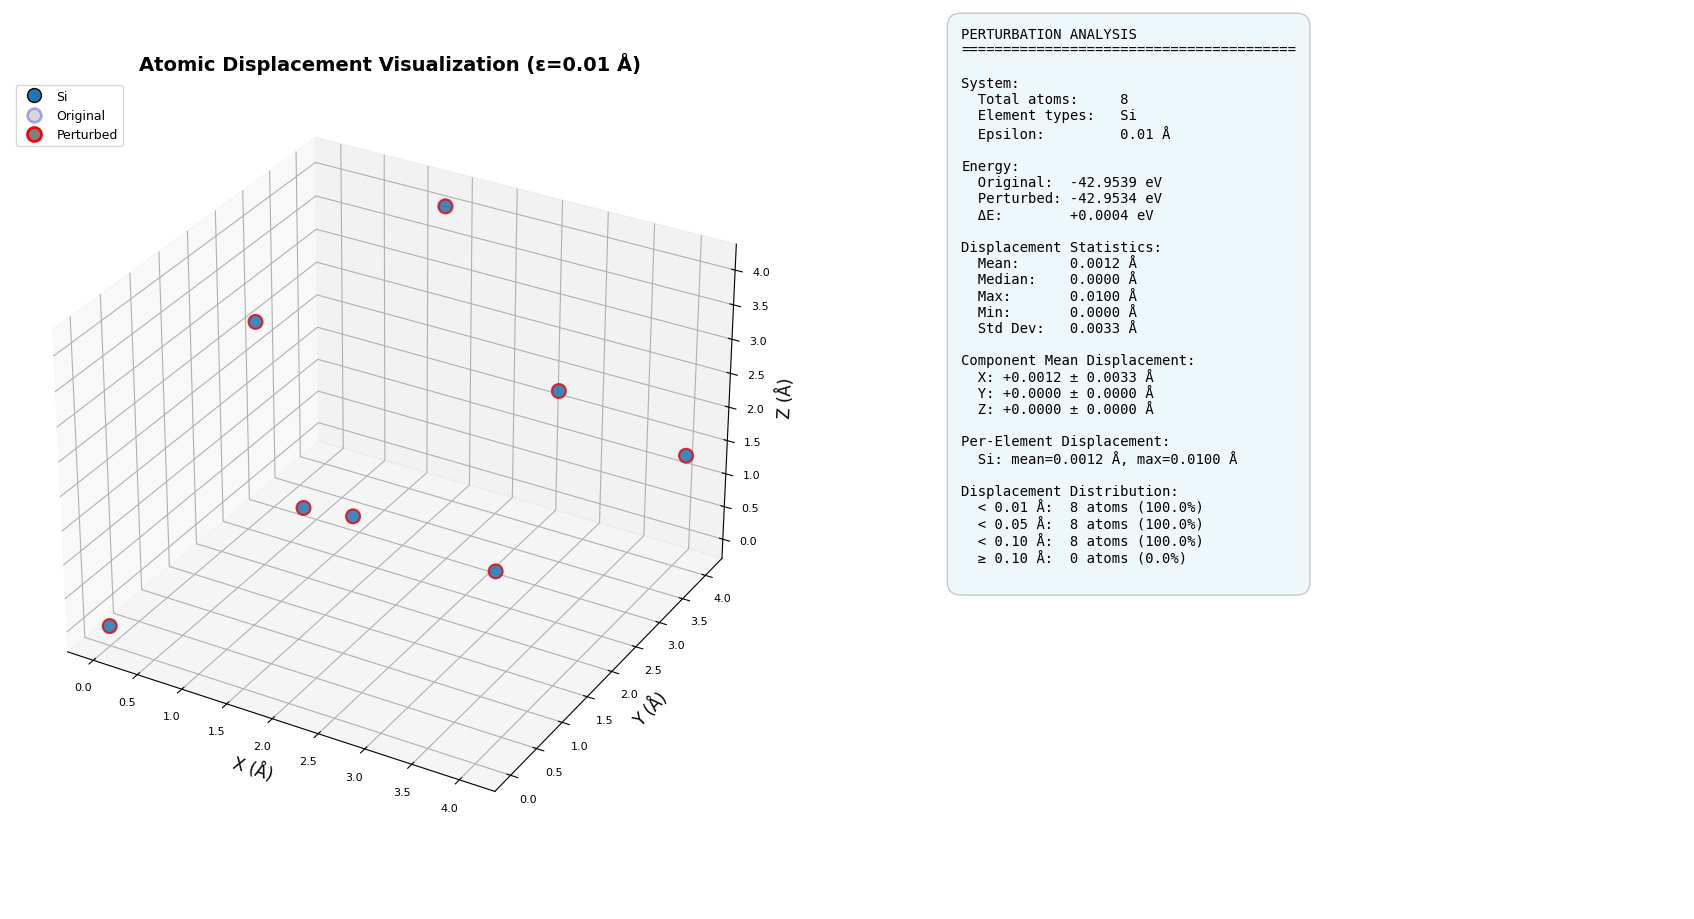

In [15]:
fig = visualize_perturbation(atom_calc, perturbed_atoms, epsilon=epsilon, outdir=None)

In [16]:
fgsm.attack_history.keys()

dict_keys(['energies', 'max_forces', 'perturbations', 'gradients'])

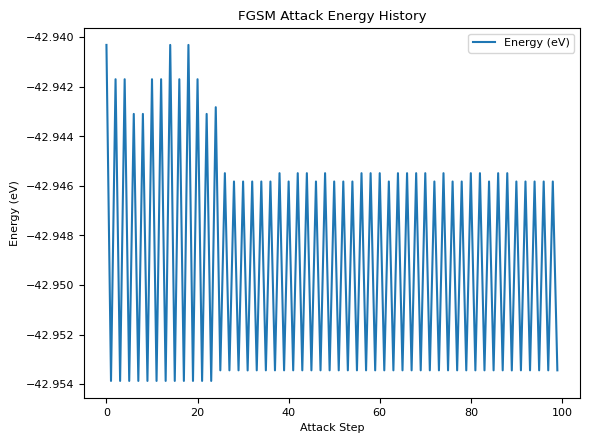

In [17]:
fig, ax = plt.subplots()
ax.plot(fgsm.attack_history['energies'], label='Energy (eV)')
ax.set_xlabel('Attack Step')
ax.set_ylabel('Energy (eV)')
ax.set_title('FGSM Attack Energy History')
ax.legend()

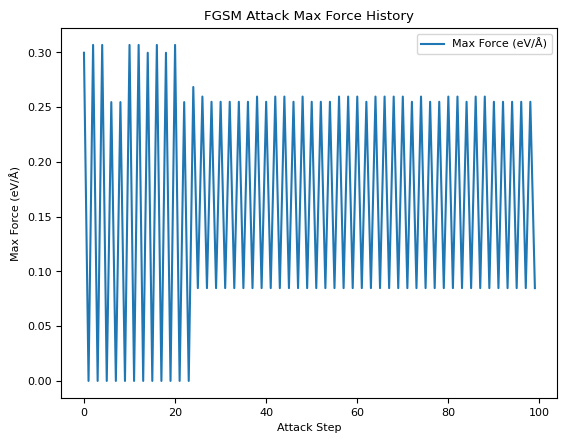

In [18]:
fig, ax = plt.subplots()
ax.plot(fgsm.attack_history['max_forces'], label='Max Force (eV/Å)')
ax.set_xlabel('Attack Step')
ax.set_ylabel('Max Force (eV/Å)')
ax.set_title('FGSM Attack Max Force History')
ax.legend()

# 5. Execute Attack

In [19]:
_ = run_relaxation(perturbed_atoms, traj_path='perturbed.traj',)

[INFO] Starting relaxation with LBFGS optimizer
[INFO] Convergence criterion: fmax = 0.01 eV/Å
[INFO] Maximum steps: 300
[INFO] Relaxation CONVERGED after 2 steps
[INFO] Final maximum force: 0.008047 eV/Å
